#### Weekly Dataset

Each week, I'm dedicating myself to exploring, modeling, and doing stuff with a dataset. Trying to master different modalities and such while reviewing different statistical tests I don't use as often as I should.

This week, we're going morbid with Homecide data. You can find the dataset home <a href="https://www.kaggle.com/datasets/joebeachcapital/homicides">here</a> on kaggle. Shoutout to <a href="https://www.linkedin.com/in/joakim-arvidsson-7a2ab8/">Joakim Arvidsson</a> for providing the data on kaggle.

In [1]:
# standard DS helper guys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# for fancy plots
import plotly_express as px
import plotly.graph_objects as go

import statsmodels.api as sm

In [2]:
# read in file with correct encoding
df = pd.read_csv("/kaggle/input/homicides/homicide-data.csv", encoding="latin1")

## EDA and Clean Data

This is the way of a data scientist: look at data from summary stats. This can help see what you have and what questions you want to ask.

In [3]:
df.head()

,uid,reported_date,victim_last,victim_first,victim_race,victim_age,victim_sex,city,state,lat,lon,disposition
0,Alb-000001,20100504,GARCIA,JUAN,Hispanic,78,Male,Albuquerque,NM,35.095788,-106.538555,Closed without arrest
1,Alb-000002,20100216,MONTOYA,CAMERON,Hispanic,17,Male,Albuquerque,NM,35.056810,-106.715321,Closed by arrest
2,Alb-000003,20100601,SATTERFIELD,VIVIANA,White,15,Female,Albuquerque,NM,35.086092,-106.695568,Closed without arrest
3,Alb-000004,20100101,MENDIOLA,CARLOS,Hispanic,32,Male,Albuquerque,NM,35.078493,-106.556094,Closed by arrest
4,Alb-000005,20100102,MULA,VIVIAN,White,72,Female,Albuquerque,NM,35.130357,-106.580986,Closed without arrest


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52179 entries, 0 to 52178
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   uid            52179 non-null  object 
 1   reported_date  52179 non-null  int64  
 2   victim_last    52178 non-null  object 
 3   victim_first   52179 non-null  object 
 4   victim_race    52179 non-null  object 
 5   victim_age     52179 non-null  object 
 6   victim_sex     52179 non-null  object 
 7   city           52179 non-null  object 
 8   state          52179 non-null  object 
 9   lat            52119 non-null  float64
 10  lon            52119 non-null  float64
 11  disposition    52179 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 4.8+ MB


In [5]:
df.describe()

,reported_date,lat,lon
count,5.217900e+04,52119.000000,52119.000000
mean,2.013090e+07,37.026786,-91.471094
std,1.123420e+06,4.348647,13.746378
min,2.007010e+07,25.725214,-122.507779
25%,2.010032e+07,33.765203,-95.997198
50%,2.012122e+07,38.524973,-87.710286
75%,2.015091e+07,40.027627,-81.755909
max,2.015111e+08,45.051190,-71.011519


In [6]:
df.isnull().sum()

uid               0
reported_date     0
victim_last       1
victim_first      0
victim_race       0
victim_age        0
victim_sex        0
city              0
state             0
lat              60
lon              60
disposition       0
dtype: int64

Null values are coming out of lat and lon and only one last name of a victim. Not bad. We can cross that if/when we need lat and lon.

In [7]:
# uid is direct
len(df["uid"].unique()) == df.shape[0]

True

In [8]:
df["victim_race"].unique()

array(['Hispanic', 'White', 'Other', 'Black', 'Asian', 'Unknown'],
      dtype=object)

In [9]:
df["victim_age"].unique()

array(['78', '17', '15', '32', '72', '91', '52', '56', '43', '20',
       'Unknown', '46', '16', '54', '22', '49', '25', '47', '88', '27',
       '36', '1', '58', '42', '50', '3', '21', '19', '95', '24', '41',
       '51', '18', '8', '64', '30', '2', '39', '45', '31', '0', '23',
       '28', '35', '26', '40', '94', '33', '57', '55', '29', '53', '66',
       '5', '74', '69', '37', '59', '34', '38', '44', '14', '9', '65',
       '90', '48', '62', '60', '4', '70', '10', '11', '63', '6', '73',
       '75', '68', '101', '13', '77', '92', '71', '82', '61', '12', '84',
       '76', '67', '81', '89', '83', '85', '80', '86', '79', '97', '7',
       '96', '87', '93', '99', '102'], dtype=object)

In [12]:
df["victim_sex"].unique()

array(['Male', 'Female', 'Unknown'], dtype=object)

In [13]:
# looks like only big cities are recorded
df["city"].unique()

array(['Albuquerque', 'Atlanta', 'Baltimore', 'Baton Rouge', 'Birmingham',
       'Boston', 'Buffalo', 'Charlotte', 'Chicago', 'Cincinnati',
       'Columbus', 'Dallas', 'Denver', 'Detroit', 'Durham', 'Fort Worth',
       'Fresno', 'Houston', 'Indianapolis', 'Jacksonville', 'Kansas City',
       'Las Vegas', 'Long Beach', 'Los Angeles', 'Louisville', 'Memphis',
       'Miami', 'Milwaukee', 'Minneapolis', 'Nashville', 'New Orleans',
       'New York', 'Oakland', 'Oklahoma City', 'Omaha', 'Philadelphia',
       'Phoenix', 'Pittsburgh', 'Richmond', 'San Antonio', 'Sacramento',
       'Savannah', 'San Bernardino', 'San Diego', 'San Francisco',
       'St. Louis', 'Stockton', 'Tampa', 'Tulsa', 'Washington'],
      dtype=object)

In [14]:
# what's wI?
df["state"].unique()

array(['NM', 'GA', 'MD', 'LA', 'AL', 'MA', 'NY', 'NC', 'IL', 'OH', 'TX',
       'CO', 'MI', 'CA', 'IN', 'FL', 'MO', 'NV', 'KY', 'TN', 'wI', 'MN',
       'OK', 'NE', 'PA', 'AZ', 'VA', 'DC'], dtype=object)

In [15]:
# Wisconsin it is
df.loc[df["state"] == "wI"].head()

,uid,reported_date,victim_last,victim_first,victim_race,victim_age,victim_sex,city,state,lat,lon,disposition
33719,Mil-000001,20130819,TYSZKO,DEBRA,White,59,Female,Milwaukee,wI,42.939756,-87.949036,Closed without arrest
33720,Mil-000002,20140411,HERNANDEZ,GILBERT,Hispanic,32,Male,Milwaukee,wI,42.954633,-87.930618,Open/No arrest
33721,Mil-000003,20090928,HARRIS,DEREK,White,22,Male,Milwaukee,wI,42.960347,-87.930184,Closed by arrest
33722,Mil-000004,20130408,BAUTCH,ANNEMARIE,White,39,Female,Milwaukee,wI,42.964593,-87.917296,Closed without arrest
33723,Mil-000005,20101231,CHRISTENSON-SUKKERT,ANGELA,White,40,Female,Milwaukee,wI,42.964790,-87.947897,Closed by arrest


Reported data seems to be in format YYYYMMDD, meaning YYYY-MM-DD. We need to slice that up to make it a date.

In [16]:
# carve up date to be in format that is pandas readable
df["reported_date"] = df["reported_date"].apply(
    lambda x: f"{str(x)[:4]}-{str(x)[4:6]}-{str(x)[6:] if len(str(x)[6:]) == 2 else str(x)[7:]}")

df["reported_date"] = pd.to_datetime(df["reported_date"])

In [17]:
# spans all time from 2007 to 2017. Ten years worth of data
df["reported_date"].min(), df["reported_date"].max()

(Timestamp('2007-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [18]:
df["day_of_week"] = df["reported_date"].dt.day_of_week
df["month"] = df["reported_date"].dt.month

In [19]:
df.day_of_week.unique()

array([1, 4, 5, 2, 3, 0, 6], dtype=int32)

In [20]:
day_name_mapping = {0: "Monday",
                    1: "Tuesday",
                    2: "Wednesday",
                    3: "Thursday",
                    4: "Friday",
                    5: "Saturday",
                    6: "Sunday",}

day_reverse_mapping = {v:k for k,v in day_name_mapping.items()}

In [21]:
df["day_of_week_name"] = df["day_of_week"].map(day_name_mapping)

In [22]:
day_homicides = df.groupby("day_of_week_name", as_index=False).count()[["day_of_week_name", "uid"]]

In [23]:
day_homicides["order"] = day_homicides["day_of_week_name"].map(day_reverse_mapping)

In [24]:
day_homicides \
.sort_values(by="order")

,day_of_week_name,uid,order
1,Monday,7564,0
5,Tuesday,6972,1
6,Wednesday,6872,2
4,Thursday,6723,3
0,Friday,7095,4
2,Saturday,8348,5
3,Sunday,8605,6


<Axes: title={'center': 'Homicide Count by Day'}, xlabel='Day of Week', ylabel='Homicide Count'>

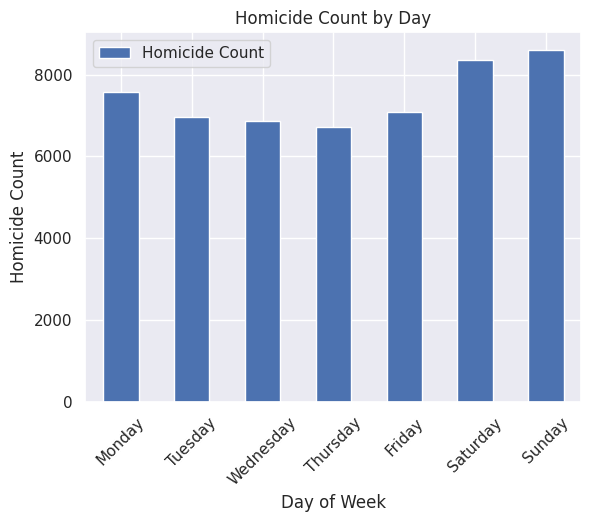

In [25]:
day_homicides \
.sort_values(by="order") \
.rename(columns={"uid": "Homicide Count"}) \
.plot(kind="bar",
      x="day_of_week_name",
      y="Homicide Count",
      xlabel="Day of Week",
      ylabel="Homicide Count",
      rot=45,
      title="Homicide Count by Day")

In [26]:
df["month_name"] = df["reported_date"].dt.month_name()

<Axes: title={'center': 'Homicides by Month'}, xlabel='Month', ylabel='Homicide Count'>

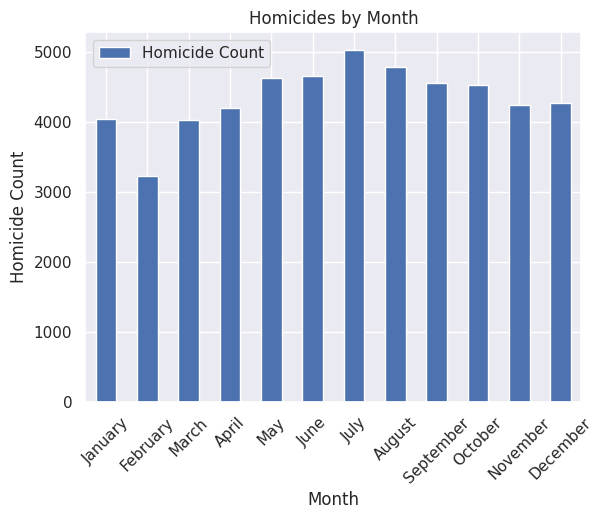

In [27]:
df.groupby(["month_name", "month"], as_index=False) \
.count()[["month_name", "month", "uid"]] \
.sort_values(by="month") \
.rename(columns={"uid": "Homicide Count"}) \
.plot(kind="bar",
      x="month_name",
      y="Homicide Count",
      xlabel="Month",
      ylabel="Homicide Count",
      title="Homicides by Month",
      rot=45)

In [28]:
df["victim_age"].min(), df["victim_age"].max()

('0', 'Unknown')

In [29]:
df.loc[df["victim_age"] == "Unknown"].shape

(2999, 16)

Text(0.5, 1.0, 'Victim Age Distribution')

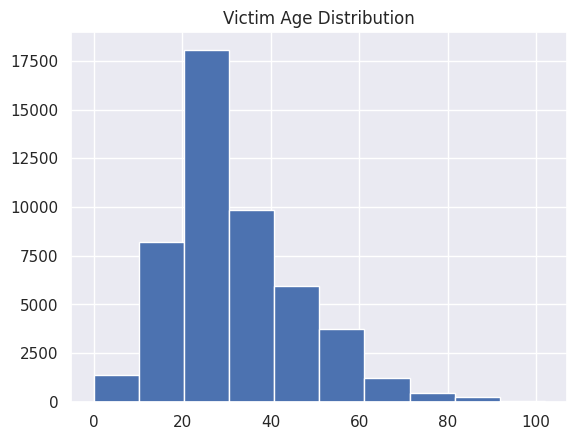

In [30]:
# distribution of age when age is known
df.loc[df["victim_age"] != "Unknown"]["victim_age"].astype(int).hist()
plt.title("Victim Age Distribution")

In [31]:
df.query("victim_age != 'Unknown'")\
.astype({"victim_age": int})[["state", "victim_age"]]\
.groupby("state", as_index=False).mean().sort_values(by="victim_age", ascending=False)

,state,victim_age
18,NV,35.433990
17,NM,35.182663
2,CO,34.573718
24,TX,33.580848
12,MI,33.541049
5,GA,33.537375
0,AL,33.407360
4,FL,33.273077
1,CA,33.083588
19,NY,32.809649


In [32]:
df.groupby("victim_sex").count()[["uid"]]

,uid
victim_sex,
Female,7209
Male,40739
Unknown,4231


In [33]:
# mainly men
df.groupby("victim_sex").count()[["uid"]] / df.shape[0]

,uid
victim_sex,
Female,0.138159
Male,0.780755
Unknown,0.081086


In [34]:
# no unknowns for dispoition. This is a clear label
df["disposition"].unique()

array(['Closed without arrest', 'Closed by arrest', 'Open/No arrest'],
      dtype=object)

In [35]:
df.groupby("disposition").count()["uid"]

disposition
Closed by arrest         25674
Closed without arrest     2922
Open/No arrest           23583
Name: uid, dtype: int64

In [36]:
df.groupby("disposition").count()["uid"] / df.shape[0]

disposition
Closed by arrest         0.492037
Closed without arrest    0.056000
Open/No arrest           0.451963
Name: uid, dtype: float64

### Questions of Interest

1.) Which state has the highest number of homicides?<br>
2.) Is the homicide rate increasing or decreasing?<br>
3.) Does race or age or gender affect solve rate for a homicide?<br>
4.) Can we predict if a case will be solved?

## 1.) What State Has the Highest Number of Homicides?

For this, we'll do a simple group by then looks at counts in a nice map. This can help up the geo-data skills a bit.

In [37]:
homicides_by_state = df.groupby("state", as_index=False)\
.count()[["state", "victim_first"]]\
.sort_values(by="victim_first", ascending=False)

In [38]:
homicides_by_state

,state,victim_first
2,CA,6288
25,TX,5891
7,IL,5535
23,PA,3668
15,MO,2867
12,MD,2827
13,MI,2519
24,TN,2281
5,FL,2120
10,LA,1858


In [39]:
# upper case state to make merge easy
homicides_by_state["state"] = homicides_by_state["state"].str.upper()

In [40]:
# there are only 28 states, so we're missing a few here
df["state"].unique().shape

(28,)

In [41]:
fig = go.Figure(data=go.Choropleth(
    locations=homicides_by_state["state"],
    z = homicides_by_state["victim_first"].astype(float),
    locationmode = "USA-states",
    colorscale = "Reds",
    colorbar_title = "Homicides",
))

fig.update_layout(
    title_text = "Homicides from 2007-2017 by State",
    geo_scope="usa", # limite map scope to USA
)

fig.show()

This gives us a good idea of the total number, however, a better measure is usually the per capita rate. That's where we normalize or adjust based on the population. To do this, wee'll bring in a csv from github that has the state population data for 2014. That should general enough for us to use here.

In [42]:
# read directly from github
pop_data = pd.read_csv("https://gist.githubusercontent.com/bradoyler/0fd473541083cfa9ea6b5da57b08461c/raw/fa5f59ff1ce7ad9ff792e223b9ac05c564b7c0fe/us-state-populations.csv")

In [43]:
pop_data.head()

,code,state,pop_2014
0,AL,Alabama,4849377
1,AK,Alaska,736732
2,AZ,Arizona,6731484
3,AR,Arkansas,2966369
4,CA,California,38802500


In [44]:
homicide_with_pop = homicides_by_state.merge(pop_data[["code", "pop_2014"]], 
                                             left_on="state",
                                             right_on="code", 
                                             how="inner")[["state", "victim_first", "pop_2014"]]

In [45]:
homicide_with_pop.head()

,state,victim_first,pop_2014
0,CA,6288,38802500
1,TX,5891,26956958
2,IL,5535,12880580
3,PA,3668,12787209
4,MO,2867,6063589


The usual metrics is per 1000 people. Let's use that here, too.

In [46]:
homicide_with_pop["homicide_per_100_000"] = 100_000 * homicide_with_pop["victim_first"] / (homicide_with_pop["pop_2014"])

In [47]:
homicide_with_pop.sort_values(by="homicide_per_100_000", ascending=False)

,state,victim_first,pop_2014,homicide_per_100_000
12,DC,1345,658893,204.130261
11,NV,1381,2839099,48.642192
5,MD,2827,5976407,47.302669
4,MO,2867,6063589,47.282228
2,IL,5535,12880580,42.971667
9,LA,1858,4649676,39.959774
7,TN,2281,6549352,34.827873
14,OK,1255,3878051,32.361617
3,PA,3668,12787209,28.684915
6,MI,2519,9909877,25.419084


In [48]:
fig = go.Figure(data=go.Choropleth(
    locations=homicide_with_pop["state"],
    z = homicide_with_pop["homicide_per_100_000"].astype(float),
    locationmode = "USA-states",
    colorscale = "Reds",
    colorbar_title = "Homicides per 100,000 Residents",
))

fig.update_layout(
    title_text = "Homicide Rate from 2007-2017 by State",
    geo_scope="usa", # limite map scope to USA
)

fig.show()

Considering these rate, DC is not where you want to be. However, this view give California a better shake: more people means more homicides, but a rate normalizes to reflect the reality of how often a murder is happening.

## 2.) Is the homicide rate increasing or decreasing?

For this, we have a simple time series chart. We only have 10 years worth of data, but worth a look. We'll do a simple less squares regression, see if it's statistically significant, and then plot it along with 

In [49]:
# add a year column
df["year"] = df["reported_date"].dt.year

In [50]:
yearly_homicides = df.groupby("year", as_index=False)\
.count()[["year", "victim_first"]]\
.rename(columns={"victim_first": "homicides"})

<Axes: title={'center': 'Homicides by Year'}, xlabel='Year', ylabel='Total Homicides'>

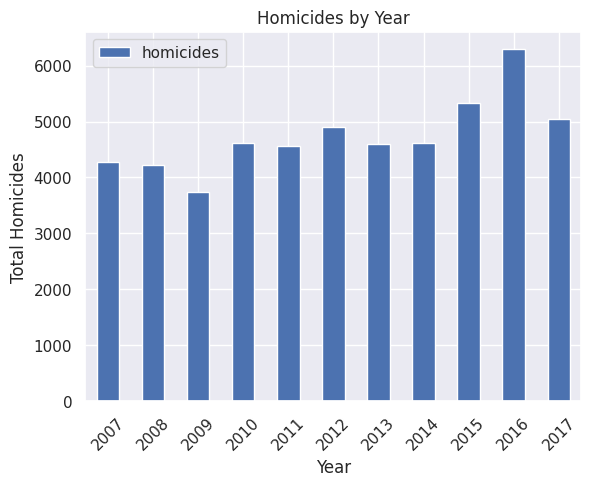

In [51]:
yearly_homicides.plot(kind="bar", 
                      x="year", 
                      y="homicides",
                      title="Homicides by Year",
                      xlabel="Year",
                      ylabel="Total Homicides",
                      rot=45)

In [52]:
X = sm.add_constant(yearly_homicides["year"])
y = yearly_homicides["homicides"]

In [53]:
model = sm.OLS(y, X)
results = model.fit()

In [54]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              homicides   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     12.93
Date:                Sun, 24 Sep 2023   Prob (F-statistic):            0.00579
Time:                        18:38:51   Log-Likelihood:                -81.749
No. Observations:                  11   AIC:                             167.5
Df Residuals:                       9   BIC:                             168.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.069e+05   8.67e+04     -3.541      0.0

/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=11



In [55]:
results.params

const   -306860.381818
year        154.872727
dtype: float64

In [56]:
yearly_homicides["fit_line"] = yearly_homicides["year"] * results.params.year + results.params.const

In [57]:
yearly_homicides

,year,homicides,fit_line
0,2007,4268,3969.181818
1,2008,4215,4124.054545
2,2009,3735,4278.927273
3,2010,4610,4433.800000
4,2011,4562,4588.672727
5,2012,4908,4743.545455
6,2013,4599,4898.418182
7,2014,4608,5053.290909
8,2015,5336,5208.163636
9,2016,6290,5363.036364


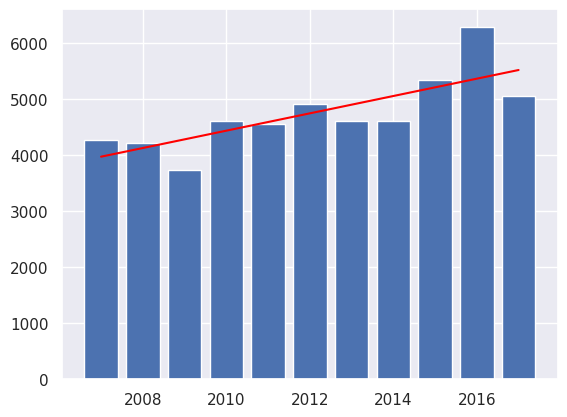

In [58]:
fig, ax = plt.subplots()

ax.bar(yearly_homicides["year"], yearly_homicides["homicides"])
ax.plot(yearly_homicides["year"], yearly_homicides["fit_line"], c="red")

I hesitate to say that this definiately shows that homicides are going up. AS you can see from the chart, 2016 is noticeably larger than the other points. It's possible that this slight outlier is causing the trend. Let's actually do something that's not extremely rigourous an take the make number, swap it with the middle number, re-run our regression. This might show that that year of homicides is just skewing us towards a positive curve.

In [59]:
mid_year = yearly_homicides.shape[0] // 2
index_2016 = yearly_homicides.loc[yearly_homicides["year"] == 2016, "homicides"].index.values[0]

In [60]:
mid_year, index_2016

(5, 9)

In [61]:
yearly_homicides.loc[index_2016, "homicides"]

6290

In [62]:
# swap 2016 val with mid value, this case, 2012
yearly_homicides.loc[mid_year, "homicides"], yearly_homicides.loc[index_2016, "homicides"] = \
yearly_homicides.loc[index_2016, "homicides"], yearly_homicides.loc[mid_year, "homicides"]

In [63]:
yearly_homicides

,year,homicides,fit_line
0,2007,4268,3969.181818
1,2008,4215,4124.054545
2,2009,3735,4278.927273
3,2010,4610,4433.800000
4,2011,4562,4588.672727
5,2012,6290,4743.545455
6,2013,4599,4898.418182
7,2014,4608,5053.290909
8,2015,5336,5208.163636
9,2016,4908,5363.036364


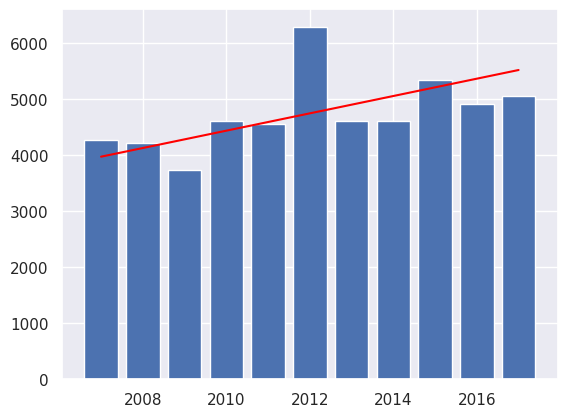

In [64]:
fig, ax = plt.subplots()

ax.bar(yearly_homicides["year"], yearly_homicides["homicides"])
ax.plot(yearly_homicides["year"], yearly_homicides["fit_line"], c="red")

In [65]:
X = sm.add_constant(yearly_homicides["year"])
y = yearly_homicides["homicides"]

model = sm.OLS(y, X)
results = model.fit()

In [66]:
yearly_homicides["fit_line"] = yearly_homicides["year"] * results.params.year + results.params.const

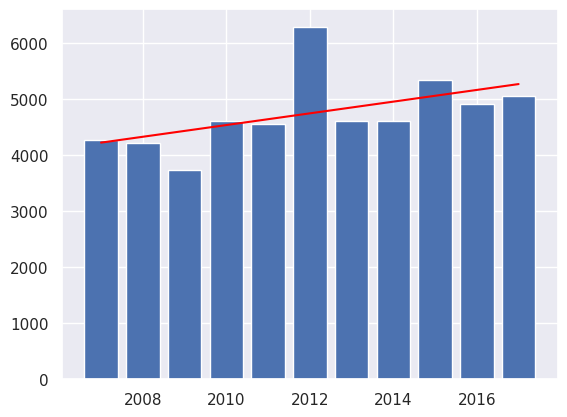

In [67]:
fig, ax = plt.subplots()

ax.bar(yearly_homicides["year"], yearly_homicides["homicides"])
ax.plot(yearly_homicides["year"], yearly_homicides["fit_line"], c="red")

In [68]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              homicides   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     3.313
Date:                Sun, 24 Sep 2023   Prob (F-statistic):              0.102
Time:                        18:38:58   Log-Likelihood:                -84.923
No. Observations:                  11   AIC:                             173.8
Df Residuals:                       9   BIC:                             174.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.057e+05   1.16e+05     -1.779      0.1

/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=11



So while our line is techically still going up, we see that our t-tests fail for this regression. So swapping the highest value with a mid-value destroies our significance.

## 3.) Does race or age or gender affect solve rate for a homicide?

This datasets contains whether or not homicide was solved or not. The proper labels are either open, closed by arrest, or closed without arrest.

We can assume closed without arrested and open are roughly the same. Open might be more recent cases. Let's see if open cases occur in the more recent years.

In [69]:
df["disposition"].unique()

array(['Closed without arrest', 'Closed by arrest', 'Open/No arrest'],
      dtype=object)

In [70]:
df.groupby(["disposition", "year"]).count()[["uid"]]

uid
disposition           year      
Closed by arrest      2007  2320
                      2008  2284
                      2009  2091
                      2010  2461
                      2011  2289
                      2012  2485
                      2013  2353
                      2014  2311
                      2015  2511
                      2016  2631
                      2017  1938
Closed without arrest 2007   303
                      2008   279
                      2009   259
                      2010   274
                      2011   260
                      2012   262
                      2013   275
                      2014   255
                      2015   286
                      2016   238
                      2017   231
Open/No arrest        2007  1645
                      2008  1652
                      2009  1385
                      2010  1875
                      2011  2013
                      2012  2161
                      2013  1971
                      2014  2042
                      2015  2539
                      2016  3421
                      2017  2879

So looks like closed without arrest is the most rare one. That makes sense. You don't want to close a case unless there's some particular reason. Maybe these cases show no one is at fault? Like self-defence cases or accidents? 

In order to not muddy the waters, we'll exlude that label from our tests and only look at open vs closed by arrest case. We want to use a statistical test to see if during this ten year period, the solve or close rate for cases between races, genders, or age is statisticall significant.

To do this, we'll use a chi-squared test since both our indepent variables (race, age, gender) are catgorical and our dependent variable (closed or not) is also categorical.

We'll start with race.

In [71]:
df.loc[df["disposition"] != "Closed without arrest"].shape, df.shape

((49257, 17), (52179, 17))

In [72]:
df_binary = df.loc[df["disposition"] != "Closed without arrest"]

In [73]:
pd.pivot_table(df_binary, 
               index="victim_race", 
               columns="disposition",
               values="uid",
               aggfunc="count")

disposition,Closed by arrest,Open/No arrest
victim_race,,
Asian,410,203
Black,15462,16403
Hispanic,3332,3168
Other,366,304
Unknown,2145,1734
White,3959,1771


We want race to not be unknown or other. We want there to be a definitive label for the race of a victim, so we'll drop "other" and "unknow" from our data.

In [74]:
df_binary = df_binary.loc[~df_binary["victim_race"].isin(["Other", "Unknown"])]

In [75]:
df_binary["victim_race"].unique()

array(['Hispanic', 'White', 'Black', 'Asian'], dtype=object)

In [76]:
pivot_table = pd.pivot_table(df_binary,
                             index="victim_race",
                             columns="disposition",
                             values="uid",
                             aggfunc="count")

In [77]:
pivot_table

disposition,Closed by arrest,Open/No arrest
victim_race,,
Asian,410,203
Black,15462,16403
Hispanic,3332,3168
White,3959,1771


In [78]:
# sum the rows and then divide each cell by row sum
pivot_table.apply(lambda x: x / x.sum(), axis=1)

disposition,Closed by arrest,Open/No arrest
victim_race,,
Asian,0.668842,0.331158
Black,0.485235,0.514765
Hispanic,0.512615,0.487385
White,0.690925,0.309075


Just from a quick look, it appears black and hispanic homicides have a 50/50 solve rate, while white and Asian cases have a much higher rate. Close to 70%.

To make this statisically roboust though, scipy has a handy function called chi2_contingency. You feed it a contengency table then it spits out all your chi-squared stuff. 

Before we run the test though, we need to set our p-value. We'll do the conventional 0.05 for a p-value.

In [79]:
from scipy.stats import chi2_contingency

In [80]:
chi2_contingency(pivot_table.values)

Chi2ContingencyResult(statistic=879.9108643874843, pvalue=2.015745245936622e-190, dof=3, expected_freq=array([[  317.59235484,   295.40764516],
       [16509.10340431, 15355.89659569],
       [ 3367.61877069,  3132.38122931],
       [ 2968.68547016,  2761.31452984]]))

The results her show us that closed rate does change by race. We can't say for certain what race is better or worse, but that race does factor into solve rate. 

To dig in a bit further, we can focus on two races and compare their average solve rates. Since black and white are our largest groups and those two groups make up a look of social debate, we'll run a t-test on those two groups. We'll randomly sample 100 instances from each group, calculate the average solve rate of each 100 sample pull. We'll do this 1000 times and compare.

In [81]:
# create numeric variable for disposition
df_binary["disposition"] = df_binary["disposition"].map(lambda x: 1 if x == "Closed by arrest" else 0)

We'll set up our experiment as follows: we're randomly sample 100 homicides for both white and black victims. We take the average of the disposition aka the percent solved rate for those 100 samples. We do this 1000 times and do a t-test between the black and white group sample averages.

In [82]:
white_solved = list()
black_solved = list()

for _ in range(1000):
    white_solved.append(df_binary.loc[df_binary["victim_race"] == "White"].sample(100)["disposition"].mean())
    black_solved.append(df_binary.loc[df_binary["victim_race"] == "Black"].sample(100)["disposition"].mean())

In [83]:
sample_data = pd.DataFrame({"race": ["black" for _ in range(1000)] + ["white" for _ in range(1000)],
                            "solved_average": black_solved + white_solved})

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



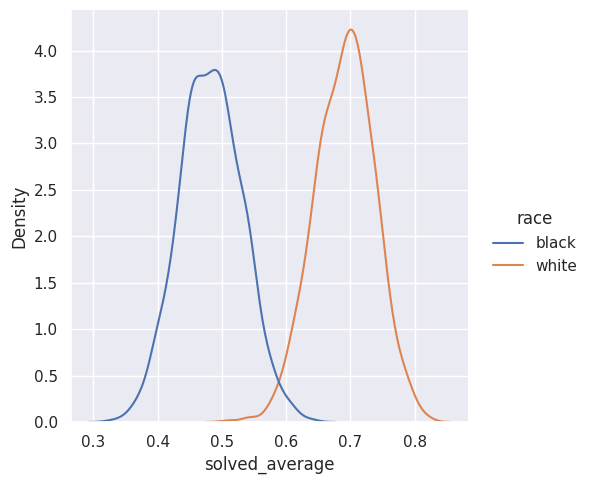

In [84]:
sns.displot(data=sample_data, x="solved_average", hue="race", kind="kde")

Just from our chart, we can see the average solve rate is much higher for white victims than black victims. To make this statistically clear though, we'll run a two way t-test.

In [85]:
from statsmodels.stats.weightstats import ttest_ind

In [86]:
ttest_ind(white_solved, black_solved)

(97.96119339635938, 0.0, 1998.0)

The p-value is effectly zero. We can confidently reject the null hypothesis and say the solve rate is not the same for black and white victims.

Let's do the same for sex and see if we come to a similar conclusion.

In [87]:
df["victim_sex"].unique()

array(['Male', 'Female', 'Unknown'], dtype=object)

In [88]:
df_binary_sex = df.loc[(df["victim_sex"] != "Unknown") & (df["disposition"] != "Closed without arrest")] 

In [89]:
pivot_table_sex = pd.pivot_table(df_binary_sex,
                                 index="victim_sex",
                                 columns="disposition",
                                 values="uid",
                                 aggfunc="count")

pivot_table_sex

disposition,Closed by arrest,Open/No arrest
victim_sex,,
Female,4415,1962
Male,19092,19879


In [90]:
# sum the rows and then divide each cell by row sum
pivot_table_sex.apply(lambda x: x / x.sum(), axis=1)

disposition,Closed by arrest,Open/No arrest
victim_sex,,
Female,0.692332,0.307668
Male,0.489903,0.510097


Male victims are much less likely to be solved from our pivot table. However again, we'll put this to the test with a chi-squared test and a t-test for solved rates between men and woman.

We'll follow the same formulas from our previous experiments: p-values much be <= 0.05. For our t-test, we'll do 100 random samples average them and then repeat 1000 times.

In [91]:
chi2_contingency(pivot_table_sex.values)

Chi2ContingencyResult(statistic=898.6706648188399, pvalue=1.9089847678734484e-197, dof=1, expected_freq=array([[ 3305.63947693,  3071.36052307],
       [20201.36052307, 18769.63947693]]))

In [92]:
# create numeric variable for disposition
df_binary_sex["disposition"] = df_binary_sex["disposition"].map(lambda x: 1 if x == "Closed by arrest" else 0)

/tmp/ipykernel_32/2463883295.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [93]:
men_solved = list()
women_solved = list()

for _ in range(1000):
    men_solved.append(
        df_binary_sex.loc[df_binary_sex["victim_sex"] == "Male"].sample(100)["disposition"].mean())
    women_solved.append(
        df_binary_sex.loc[df_binary_sex["victim_sex"] == "Female"].sample(100)["disposition"].mean())

In [94]:
sample_data_sex = pd.DataFrame({"race": ["male" for _ in range(1000)] + ["female" for _ in range(1000)],
                                "solved_average": men_solved + women_solved})

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



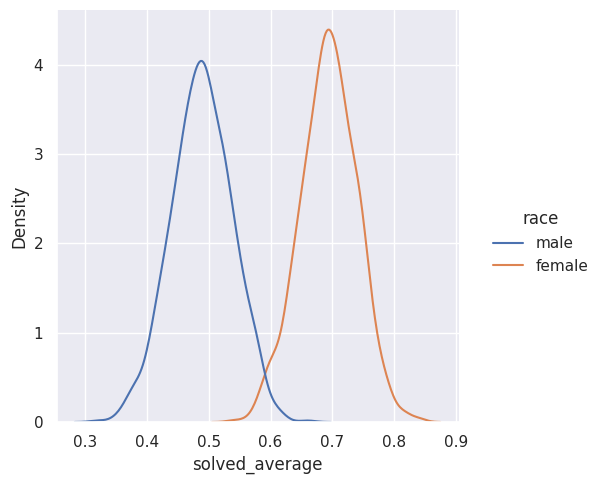

In [95]:
sns.displot(data=sample_data_sex, 
            x="solved_average", 
            hue="race", 
            kind="kde")

In [97]:
ttest_ind(men_solved, women_solved)

(-96.57530419236323, 0.0, 1998.0)

Again, we get a p-value effectively of 0 for each test, meaning we can reject our null hypothesis that the solve rate for the two groups are the same.

Since we have some evidence for the solve rate being different for each group, we can move towards the best part: ML. We can make a classifier to see if we can predict whether a case will be solved or not.

## 4.) Can we predict if a case will be solved?

Having a decent size dataset (about 50,000 here) we can try an ML approach to homicide rate closure. We'll throw a few features together and then see what we can do.

We do have a lot of unknow values in terms of age, sex, and race. We'll leave those in there for now and see what happens. We're iterate after that.

In [98]:
df_predict = df.loc[df["disposition"] != "Closed without arrest"]

In [99]:
# we start parsing out variable we think are interesting. We'll exclude year
# since we want to predict based on these ten years worth of data regardless of that
df_predict = df_predict[
    ["victim_race", "victim_age", "victim_sex", "state", "day_of_week", "month", "disposition"]
]

In [100]:
# luckily our labels are balanced. Our baseline is an accuracy better than 52% for predicting an arrest
df_predict["disposition"].value_counts() / df_predict.shape[0]

disposition
Closed by arrest    0.521225
Open/No arrest      0.478775
Name: count, dtype: float64

In [101]:
numeric_variables = ["victim_age"]
categorical_variables = ["victim_race", "victim_sex", "state", "day_of_week", "month"]

In [102]:
# change unknown age to be large negative number
df_predict["victim_age"] = df_predict["victim_age"].map(lambda x: -999 if x == "Unknown" else x).astype(int)

In [103]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, auc, confusion_matrix

In [104]:
df_predict.shape

(49257, 7)

In [105]:
# before anything, create a split
X_train, X_validation, y_train, y_validation = \
train_test_split(df_predict.drop("disposition", axis=1), 
                 df_predict["disposition"],
                 test_size=0.3,
                 random_state=42,
                 stratify=df_predict["disposition"])

In [106]:
X_val, X_test, y_val, y_test = \
train_test_split(X_validation, 
                 y_validation,
                 test_size=0.5,
                 random_state=42,
                 stratify=y_validation)

In [107]:
col_transformer = ColumnTransformer([
    ("OneHot", OneHotEncoder(drop="first", handle_unknown = "ignore"), categorical_variables),
    ("MinMax", MinMaxScaler(), numeric_variables)
])

In [108]:
pipeline = Pipeline([
    ("tranfromers", col_transformer),
    ("model", LogisticRegressionCV())
])

In [109]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tranfromers',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['victim_race', 'victim_sex',
                                                   'state', 'day_of_week',
                                                   'month']),
                                                 ('MinMax', MinMaxScaler(),
                                                  ['victim_age'])])),
                ('model', LogisticRegressionCV())])

In [110]:
accuracy_score(pipeline.predict(X_val), y_val)

0.6082013804303694

In [111]:
confusion_matrix(pipeline.predict(X_val), y_val)

array([[2618, 1662],
       [1233, 1876]])

Not great, but better than guessing. The age variable might have affected our linear logistic regression model. Let's try some non-linear models here like random forest or catboost.

In [112]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

In [113]:
pipeline_rf = Pipeline([
    ("tranfromers", col_transformer),
    ("model", RandomForestClassifier())
])

In [114]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('tranfromers',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['victim_race', 'victim_sex',
                                                   'state', 'day_of_week',
                                                   'month']),
                                                 ('MinMax', MinMaxScaler(),
                                                  ['victim_age'])])),
                ('model', RandomForestClassifier())])

In [115]:
accuracy_score(pipeline_rf.predict(X_val), y_val)

0.5699012044931655

In [116]:
confusion_matrix(pipeline_rf.predict(X_val), y_val)

array([[2343, 1670],
       [1508, 1868]])

In [202]:
col_transformer_cb = ColumnTransformer([
    ("MinMax", MinMaxScaler(), numeric_variables)
], remainder="passthrough")

pipeline_cb = Pipeline([
    ("tranforms", col_transformer_cb),
    ("model", CatBoostClassifier(verbose=False, cat_features=[1,2,3,4,5]))
])

In [203]:
pipeline_cb.fit(X_train, y_train)

Pipeline(steps=[('tranforms',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('MinMax', MinMaxScaler(),
                                                  ['victim_age'])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x7ade710a36d0>)])

In [204]:
accuracy_score(pipeline_cb.predict(X_val), y_val)

0.6188929489782109

In [205]:
confusion_matrix(pipeline_cb.predict(X_val), y_val)

array([[2516, 1481],
       [1335, 2057]])

CatBoost seems the best. We can use CatBoost and Random Forest Models to get an idea of what our models are focusing on via the feature_importances_ method.

In [206]:
pipeline_cb["model"].feature_importances_

array([20.00771853, 13.14857501, 11.12441839, 30.23848325, 11.49848598,
       13.98231885])

In [207]:
pipeline_rf["model"].feature_importances_

array([0.01121778, 0.00743257, 0.0028462 , 0.00180719, 0.01120178,
       0.01964516, 0.00140237, 0.00100047, 0.00951305, 0.00232002,
       0.00422173, 0.00728299, 0.00422006, 0.02660546, 0.00523891,
       0.00344113, 0.00497434, 0.00336972, 0.00741467, 0.00559242,
       0.00314203, 0.00611795, 0.00503165, 0.00290515, 0.00252137,
       0.00440962, 0.0049143 , 0.00605851, 0.00491704, 0.00702405,
       0.00755528, 0.00809808, 0.00268215, 0.00406041, 0.0201856 ,
       0.02116367, 0.02071118, 0.02128466, 0.02207663, 0.02191668,
       0.01243291, 0.01319625, 0.01303666, 0.01492015, 0.0146445 ,
       0.01515465, 0.01476506, 0.01496375, 0.01483009, 0.01199768,
       0.0103921 , 0.51214218])

In [208]:
variable_importance = X_train.copy()
variable_importance["day_of_week"] = variable_importance["day_of_week"].astype(str)
variable_importance["month"] = variable_importance["month"].astype(str)

In [209]:
dummy_variables = pd.get_dummies(variable_importance[categorical_variables], drop_first=True).columns.tolist()

In [210]:
dummy_variables += ["age"]

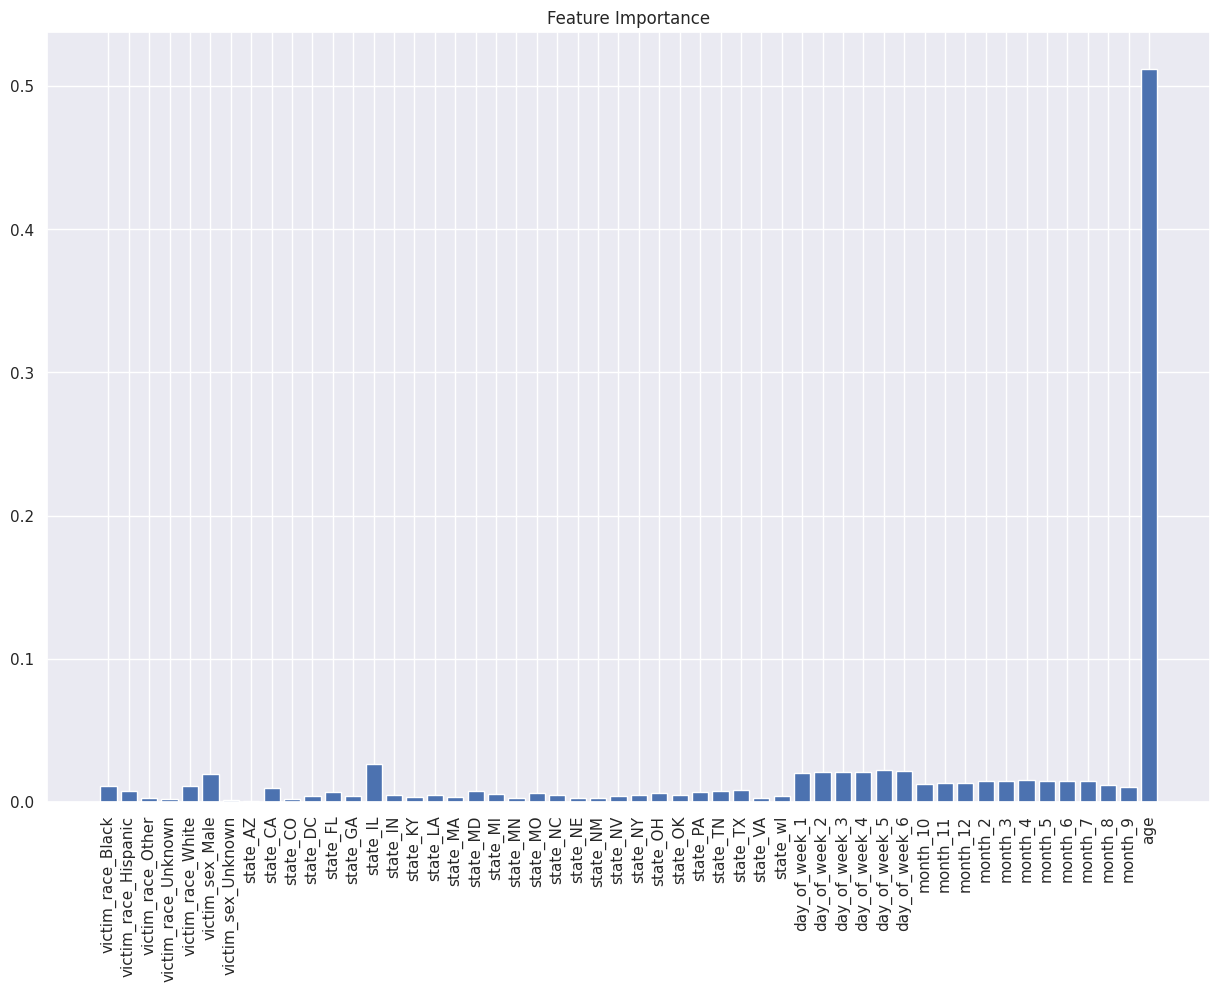

In [211]:
fix, ax = plt.subplots(figsize=(15,10))
ax.bar(dummy_variables, pipeline_rf["model"].feature_importances_)
_ = plt.xticks(rotation=90), plt.title("Feature Importance")

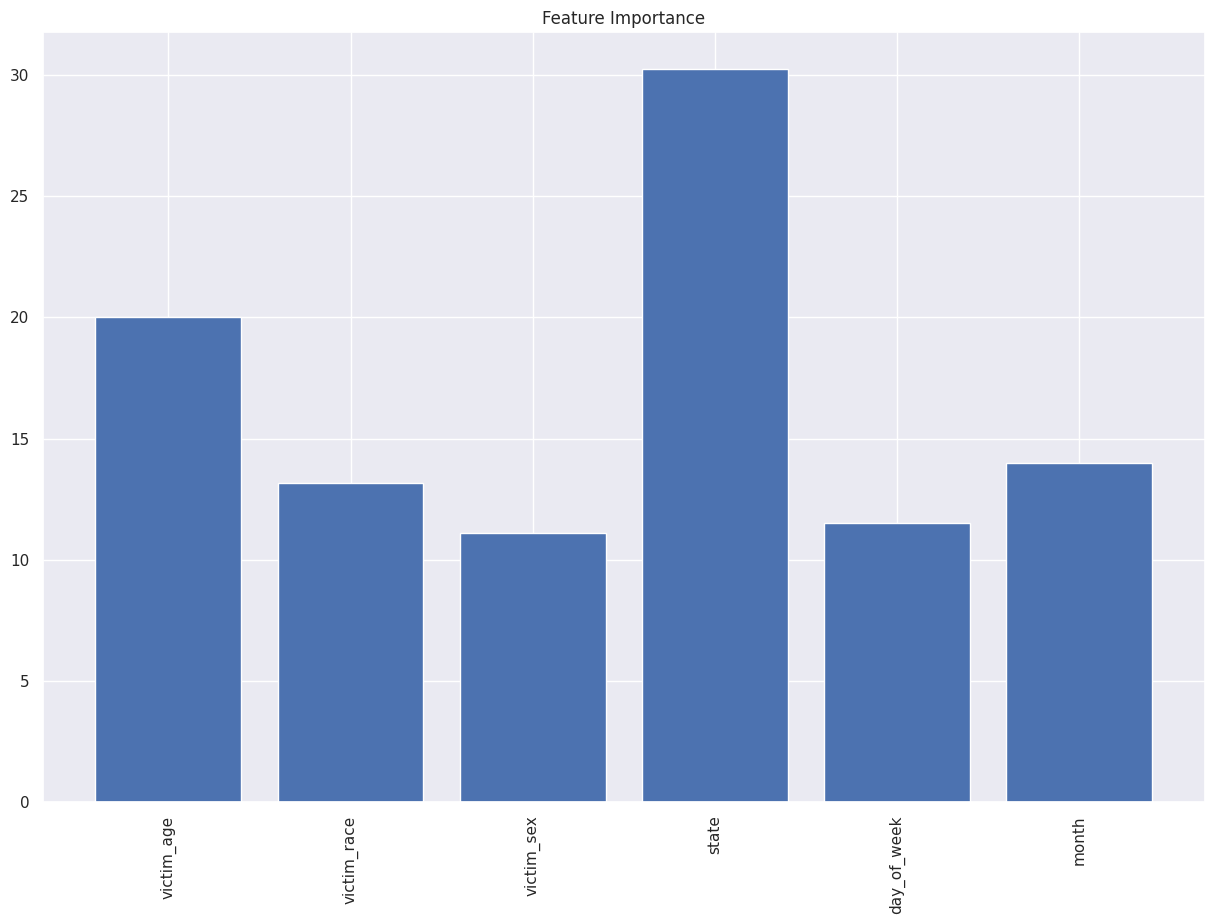

In [212]:
# cat boost can take categorical columns as features. Here, we rearrange the columns to be in the correct order
# that we passed them to catboost
cols = X_train.columns.tolist()
age_col = cols.pop(1)
df_cols = [age_col] + cols

fix, ax = plt.subplots(figsize=(15,10))
ax.bar(df_cols, pipeline_cb["model"].feature_importances_)
_ = plt.xticks(rotation=90), plt.title("Feature Importance")

The Random Forest tends to really focus on age while giving other features less importance. Catboost on the other hand, uses state more often. Note also that catboost can give feature importance over entire categorical columns, not just the dummy column variable features.

Over these three models though, we're barely getting better than random guessing. We are including the unknown data. Let's see how many of those we have across all variables.

In [213]:
X_train_no_unknown = X_train.loc[(X_train["victim_race"] != "Unknown") |
                                (X_train["victim_sex"] != "Unknown") |
                                (X_train["victim_age"] != -999)]

In [214]:
X_train_no_unknown.shape

(32786, 6)

In [215]:
y_train_no_unknown = y_train.loc[y_train.index.isin(X_train_no_unknown.index.tolist())]

In [216]:
y_train_no_unknown.shape

(32786,)

In [217]:
pipeline_cb.fit(X_train_no_unknown, y_train_no_unknown)

Pipeline(steps=[('tranforms',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('MinMax', MinMaxScaler(),
                                                  ['victim_age'])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x7ade710a36d0>)])

In [218]:
X_val_no_unknown = X_val.loc[(X_val["victim_race"] != "Unknown") |
                             (X_val["victim_sex"] != "Unknown") |
                             (X_val["victim_age"] != -999)]

y_val_no_unknown = y_val.loc[y_val.index.isin(X_val_no_unknown.index.tolist())]

In [219]:
accuracy_score(pipeline_cb.predict(X_val), y_val)

0.6153742048991745

In [220]:
pipeline.fit(X_train_no_unknown, y_train_no_unknown)

Pipeline(steps=[('tranfromers',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['victim_race', 'victim_sex',
                                                   'state', 'day_of_week',
                                                   'month']),
                                                 ('MinMax', MinMaxScaler(),
                                                  ['victim_age'])])),
                ('model', LogisticRegressionCV())])

In [221]:
accuracy_score(pipeline.predict(X_val_no_unknown), y_val_no_unknown)

0.613820560216124

In [222]:
pipeline_rf.fit(X_train_no_unknown, y_train_no_unknown)

Pipeline(steps=[('tranfromers',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['victim_race', 'victim_sex',
                                                   'state', 'day_of_week',
                                                   'month']),
                                                 ('MinMax', MinMaxScaler(),
                                                  ['victim_age'])])),
                ('model', RandomForestClassifier())])

In [223]:
accuracy_score(pipeline_rf.predict(X_val_no_unknown), y_val_no_unknown)

0.5752879283378359

Removing the unknowns didn't really do much for us. What we can try here is optimizing our hyperparameters. It might not get us a ton, but it could maybe get us to 70%? That might be a bit optimistic but we can try.

We must also remember that this might not be ML solvable problem with the data we have. There is a lot of variation between homicides. Some could be open and closed cases easily solved. Other could be more difficult that are gang related or the victim had no connection to the murderer. Heading into anything ML, you gotta keep in mind that we might be able to do ML to predict it.

Anywho, let's use industry optuna to do this. It's the fairly standard way to tune sklearn models. We'll do 100 trials with optuna, choosing some key hyperparameters from catboost.

In [227]:
y_train = y_train.map(lambda x: 1 if x == "Closed by arrest" else 0)
y_val = y_val.map(lambda x: 1 if x == "Closed by arrest" else 0)

In [230]:
import optuna

def objective(trial):
    
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    col_transformer_cb = ColumnTransformer([
    ("MinMax", MinMaxScaler(), numeric_variables)
    ], 
        remainder="passthrough")

    pipeline_cb = Pipeline([
        ("tranforms", col_transformer_cb),
        ("model", CatBoostClassifier(verbose=False, cat_features=[1,2,3,4,5], **param))
    ])
    
    pipeline_cb.fit(X_train, y_train)

    preds = pipeline_cb.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-09-24 19:20:49,908] A new study created in memory with name: no-name-3bef3797-9e81-4e77-8270-15f128152a38
[I 2023-09-24 19:21:01,811] Trial 0 finished with value: 0.6125321423737989 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08667737543247524, 'depth': 2, 'learning_rate': 0.017858746735163047, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5932356838217934}. Best is trial 0 with value: 0.6125321423737989.
[I 2023-09-24 19:21:08,220] Trial 1 finished with value: 0.6080660441196373 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.03687250462695415, 'depth': 1, 'learning_rate': 0.02890404961803916, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.8001442603951965}. Best is trial 0 with value: 0.6125321423737989.
[I 2023-09-24 19:21:15,528] Trial 2 finished with value: 0.5981864934361889 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05463674263975879, 'depth': 9, 'learni

Accuracy: 0.6199756394640682
Best hyperparameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09001866110666895, 'depth': 5, 'learning_rate': 0.07839750423070115, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5792407052121371}


From our 100 trials, we were barely able to get out of the 62% range. Might be that this problem can't really be solved via the ML solutions we have now. Might be worth future attempts to create DNN's (deep neural networks), but for now, I'm capping this and putting a bow on it.